In [2]:
import time
from typing import Dict, List
import numpy as np
import yaml
from scipy import signal
from matplotlib import pyplot as plt
import os
import pickle

from aliases import FilePath
from models import *
from utils import parse_snippet

pygame 2.0.1 (SDL 2.0.14, Python 3.9.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Load SpikerBox parameters
CONFIG_PATH: FilePath = "settings/spiker_box.srconfig"
with open(CONFIG_PATH, "r") as config_file:
    config_data: Dict = yaml.safe_load(config_file)
    # SpikerBox arguments
    buffer_time: float = float(config_data["buffer_time"])
    update_factor: float = float(config_data["update_factor"])
    wait_time: float = float(config_data["wait_time"])
    num_samples: int = int(config_data["num_samples"])
    quality_factor: float = float(config_data["quality_factor"])
    # Modified simple classifier parameters
    m_event_threshold: int = int(config_data["classifier"]["MSC"]["event_threshold"])
    positive_amplitude: float = float(config_data["classifier"]["MSC"]["positive_amplitude"])
    negative_amplitude: float = float(config_data["classifier"]["MSC"]["negative_amplitude"])
    spacing: float = float(config_data["classifier"]["MSC"]["spacing"])
    # Simple classifier parameters
    s_event_threshold: int = int(config_data["classifier"]["USC"]["event_threshold"])
    # Catch22 model paths
    knn_path: FilePath = config_data["classifier"]["KNN"]["file_path"]
    rfc_path: FilePath = config_data["classifier"]["RFC"]["file_path"]
    svc_path: FilePath = config_data["classifier"]["SVC"]["file_path"]

In [4]:
# Initialise models
modified_model: ModelBase = ModifiedModel(m_event_threshold, positive_amplitude, negative_amplitude, spacing)
simple_model: ModelBase = SimpleModel(s_event_threshold)
knn_model: ModelBase = Catch22Model.create_from_file(knn_path)
rfc_model: ModelBase = Catch22Model.create_from_file(rfc_path)
svc_model: ModelBase = Catch22Model.create_from_file(svc_path)

In [5]:
TEST_FILE: FilePath = "snippets/left1_left_1.npy"
# Load snippet
signal_slice, _ = parse_snippet(np.load(TEST_FILE))
# Standardise and downsample signal
test_data: np.ndarray = signal.resample(signal_slice, num_samples)
# Number of trials
num_trials: int = int(1e3)

In [6]:
classification_times: Dict[ModelType, List[int]] = {}

In [7]:
def time_model(model: ModelBase, num_trials: int) -> List[int]:
    performance_times: List[int] = []
    for _ in range(num_trials):
        start_time: int = time.perf_counter_ns()
        _ = model.classify(test_data)
        final_time: int = time.perf_counter_ns()
        performance_times.append((final_time - start_time) // 1e6)
    return performance_times

In [8]:
classification_times[ModelType.MSC] = time_model(modified_model, num_trials)
classification_times[ModelType.USC] = time_model(simple_model, num_trials)
classification_times[ModelType.KNN] = time_model(knn_model, num_trials)
classification_times[ModelType.RFC] = time_model(rfc_model, num_trials)
classification_times[ModelType.SVC] = time_model(svc_model, num_trials)


In [9]:
DIAGNOSTICS_FOLDER: FilePath = "diagnostics"
if not os.path.isdir(DIAGNOSTICS_FOLDER):
    os.mkdir(DIAGNOSTICS_FOLDER)

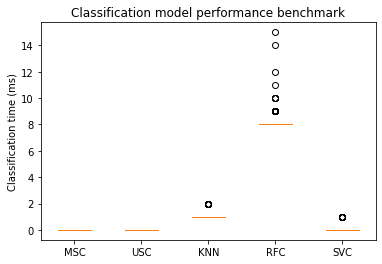

In [10]:
plt.boxplot(classification_times.values(), labels=["MSC", "USC", "KNN", "RFC", "SVC"])
plt.ylabel("Classification time (ms)")
plt.title("Classification model performance benchmark");
plt.savefig(f"{DIAGNOSTICS_FOLDER}/classification_performance_boxplot.png")

In [14]:
classification_performance_cache: FilePath = f"{DIAGNOSTICS_FOLDER}/classification_performance.pickle"
if not os.path.isfile(classification_performance_cache):
    with open(classification_performance_cache, "wb") as handle:
        pickle.dump(classification_times, handle)

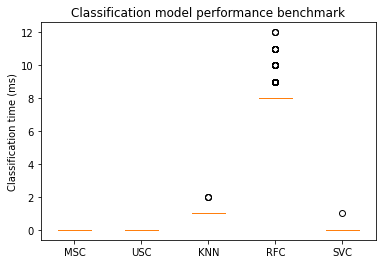

In [12]:
if os.path.isfile(classification_performance_cache):
    with open(classification_performance_cache, "rb") as handle:
        accuracy_data = pickle.load(handle)
        plt.boxplot(accuracy_data.values(), labels=["MSC", "USC", "KNN", "RFC", "SVC"])
        plt.ylabel("Classification time (ms)")
        plt.title("Classification model performance benchmark");